## This notebook demonstrates how to build a [video vision transformer](https://arxiv.org/abs/2103.15691).

***
### Videos are `sequences` of images.  Let's assume you have an image representation model (CNN, ViT, etc.) and a sequence model `(RNN, LSTM, etc.)` at hand. We ask you to tweak the model for `video classification`.

### The simplest approach would be to apply the image model to individual frames, use the sequence model to learn sequences of image features, then apply a classification head on the learned sequence representation.


### A novel embedding scheme is proposed and a number of Transformer variants to model video clips. We implement the embedding scheme and one of the variants of the Transformer architecture.

In [1]:
!pip install -qq medmnist

     |████████████████████████████████| 87 kB 844 kB/s 


In [2]:
import os
import io
import imageio
import medmnist
import ipywidgets
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#Set seed for reproducibility.
SEED = 42
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
keras.utils.set_random_seed(SEED)

In [3]:
#Hyperparameter search.
DATASET_NAME = 'organmnist3d'
BATCH_SIZE = 32
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (28, 28, 28, 1)
NUM_CLASSES = 11

#Optimizer.
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5

#TRAINING
EPOCHS = 60

#tUBELET EMBEDDING
PATCH_SIZE = (8, 8, 8)
NUM_PATCHES = (INPUT_SHAPE[0] // PATCH_SIZE[0]) ** 2

#ViViT architecture.
LAYER_NORMS_EPS = 1e-6
PROJECTION_DIM = 128
NUM_HEADS = 8
NUM_LAYERS = 8

## Prepare dataset.

In [4]:
def download_and_prepare_dataset(data_info: dict):
    '''Function to download the dataset.'''
    data_path = keras.utils.get_file(origin = data_info['url'], 
                                     md5_hash = data_info['MD5'])
    
    with np.load(data_path) as data:
        #Get the videos.
        train_videos = data['train_images']
        valid_videos = data['val_images']
        test_videos = data['test_images']
        
        #Get the labels.
        train_labels = data['train_labels'].flatten()
        valid_labels = data['val_labels'].flatten()
        test_labels = data['test_labels'].flatten()
        
    return (
        (train_videos, train_labels),
        (valid_videos, valid_labels),
        (test_videos, test_labels)
    )


info = medmnist.INFO[DATASET_NAME]

#Get the dataset.
prepared_dataset = download_and_prepare_dataset(info)

(train_videos, train_labels) = prepared_dataset[0]
(valid_videos, valid_labels) = prepared_dataset[1]
(test_videos, test_labels) = prepared_dataset[2]

32657407/32657407 [==============================] - 10s 0us/step


### tf.data pipeline.

In [5]:
@tf.function
def preprocess(frames: tf.Tensor, label: tf.Tensor):
    '''Preprocess the frames tensors and parse the labels'''
    
    #Preprocess images.
    frames = tf.image.convert_image_dtype(frames[..., tf.newaxis], tf.float32)
    
    #Parse label.
    label = tf.cast(label, tf.float32)
    return frames, label


def prepare_dataloader(videos: np.ndarray, 
                       labels: np.ndarray,
                       loader_type: str = 'train',
                       batch_size: int = BATCH_SIZE):
    dataset = tf.data.Dataset.from_tensor_slices((videos, labels))
    
    if loader_type == 'train':
        dataset = dataset.shuffle(BATCH_SIZE * 2)
        
    dataloader = (
        dataset.map(preprocess, num_parallel_calls = tf.data.AUTOTUNE)
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE))
    return dataloader



trainloader = prepare_dataloader(train_videos, train_labels, 'train')
valiloader = prepare_dataloader(valid_videos, valid_labels, 'valid')
testloader = prepare_dataloader(test_videos, test_labels, 'test')

## Tubelet embedding.
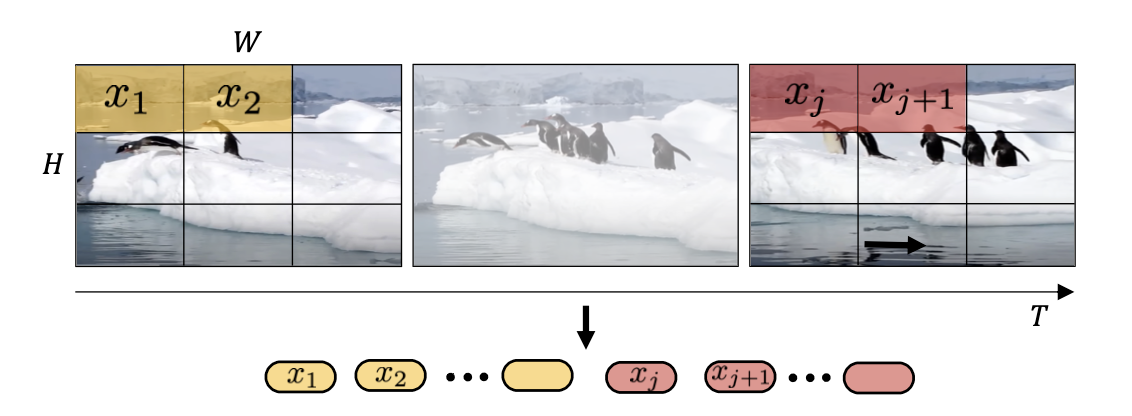

In ViTs, an image is divided into patches, which are spatially flattened(tokenization). For a video, one can repeat this process for individual frames. `Uniform random sampling` is a tokenization scheme in which we sample frames from a video clip and perform simple ViT tokenization.

***
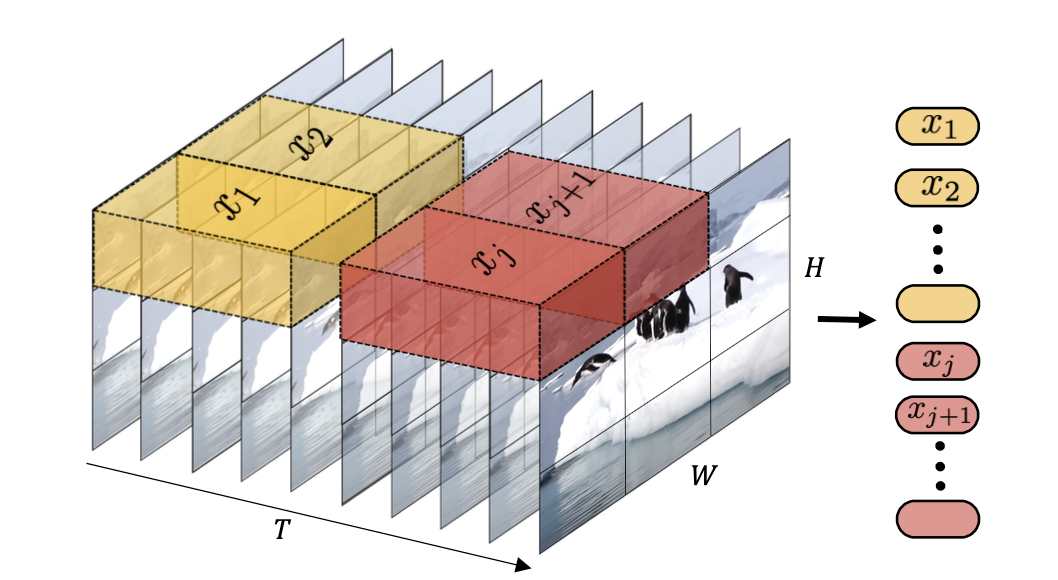

`Tubelet Embedding` is different in terms of capturing temporal information from the video. First, we extract volumes from the video -- these volumes contain patches of the frame and the temporal information as well. The volumes are then flattened to build video tokens.

In [13]:
class TubeletEmbedding(layers.Layer):
    def __init__(self, embed_dim, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.projection = layers.Conv3D(filters = embed_dim, 
                                        kernel_size = patch_size, 
                                        strides = patch_size, 
                                        padding = 'VALID')
        self.flatten = layers.Reshape(target_shape = (-1, embed_dim))
        
    def call(self, videos):
        projected_patches = self.projection(videos)
        flattened_patches = self.flatten(projected_patches)
        
        return flattened_patches

## Positional embedding.
### This layer adds positional information to the encoded video tokens.

In [7]:
class PositionalEncoder(layers.Layer):
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        
        self.embed_dim = embed_dim
        
    def build(self, input_shape):
        _, num_tokens, _ = input_shape
        self.positional_embedding = layers.Embedding(input_dim = num_tokens, 
                                                     output_dim = self.embed_dim)
        
        self.positions = tf.range(start = 0, limit = num_tokens, delta = 1)
        
    def call(self, encoded_tokens):
        #Encode the positions and add it to the encoded tokens.
        encoded_positions = self.positional_embedding(self.positions)
        encoded_tokens = encoded_tokens + encoded_positions
        return encoded_tokens

## Video Vision Transformer.

There are 4 variants of the vision transformer:
- Spatio-temporal attention
- Factorized encoder
- Factorized self-attention
- Factorized dot-product attention

The `Spatio-temporal attention` is implemented in this notebook. It is heavily inspired from [Image classification with Vision Transformer.](https://keras.io/examples/vision/image_classification_with_vision_transformer/)

In [8]:
def create_vivit_classifier(tubelet_embedder, positional_encoder, 
                            input_shape = INPUT_SHAPE, transformer_layers = NUM_LAYERS,
                            num_heads = NUM_HEADS, embed_dim = PROJECTION_DIM, layer_norm_eps = LAYER_NORMS_EPS,
                            num_classes = NUM_CLASSES):
    
    #Get the input layer.
    inputs = layers.Input(shape = input_shape)
    
    #Create patches.
    patches = tubelet_embedder(inputs)
    
    #Encode patches.
    encoded_patches = positional_encoder(patches)
    
    #Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        #Layers normalization and MHSA.
        
        x1 = layers.LayerNormalization(epsilon = 1e-6)(encoded_patches)
        
        attention_output = layers.MultiHeadAttention(
            num_heads = num_heads, key_dim = embed_dim // num_heads, dropout = 0.1)(x1, x1)
        
        #Skip connection.
        x2 = layers.Add()([attention_output, encoded_patches])
        
        #Layer normalization and MLP
        x3 = layers.LayerNormalization(epsilon = 1e-6)(x2)
        x3 = keras.Sequential([
            layers.Dense(units = embed_dim * 4, activation = tf.nn.gelu),
            layers.Dense(units = embed_dim, activation = tf.nn.gelu)
        ])(x3)
        
        #Skip connection.
        encoded_patches = layers.Add()([x3, x2])
        
    
    #Layer normalization and global average pooling.
    representation = layers.LayerNormalization(epsilon = layer_norm_eps)(encoded_patches)
    representation = layers.GlobalAvgPool1D()(representation)
    
    #Classifiy outputs.
    outputs = layers.Dense(units = num_classes, activation = 'softmax')(representation)
    
    #Create the Keras model.
    model = keras.Model(inputs, outputs)
    return model

In [9]:
def run_experiment():
    #Initialize model.
    model = create_vivit_classifier(tubelet_embedder=TubeletEmbedding(embed_dim=PROJECTION_DIM, patch_size=PATCH_SIZE),
                                    positional_encoder=PositionalEncoder(embed_dim = PROJECTION_DIM)
                                   )
    
    #Compile model.
    optimizer = keras.optimizers.Adam(learning_rate = LEARNING_RATE)
    model.compile(optimizer = optimizer,
                  loss = 'sparse_categorical_crossentropy',
                  metrics = [keras.metrics.SparseCategoricalAccuracy(name = 'accuracy'),
                             keras.metrics.SparseTopKCategoricalAccuracy(5, name = 'top-5-accuracy')
                            ])
    
    print(model.summary())
    
    _ = model.fit(trainloader, epochs = EPOCHS, validation_data = valiloader)
    
    _, accuracy, top_5_accuracy = model.evaluate(testloader)
    
    print(f'Test accuracy: {round(accuracy * 100, 2)}%')
    print(f'Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%')
    
    return model

In [10]:
model = run_experiment()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 28,  0           []                               
                                 1)]                                                              
                                                                                                  
 tubelet_embedding (TubeletEmbe  (None, 27, 128)     65664       ['input_1[0][0]']                
 dding)                                                                                           
                                                                                                  
 positional_encoder (Positional  (None, 27, 128)     3456        ['tubelet_embedding[0][0]']      
 Encoder)                                                                                     

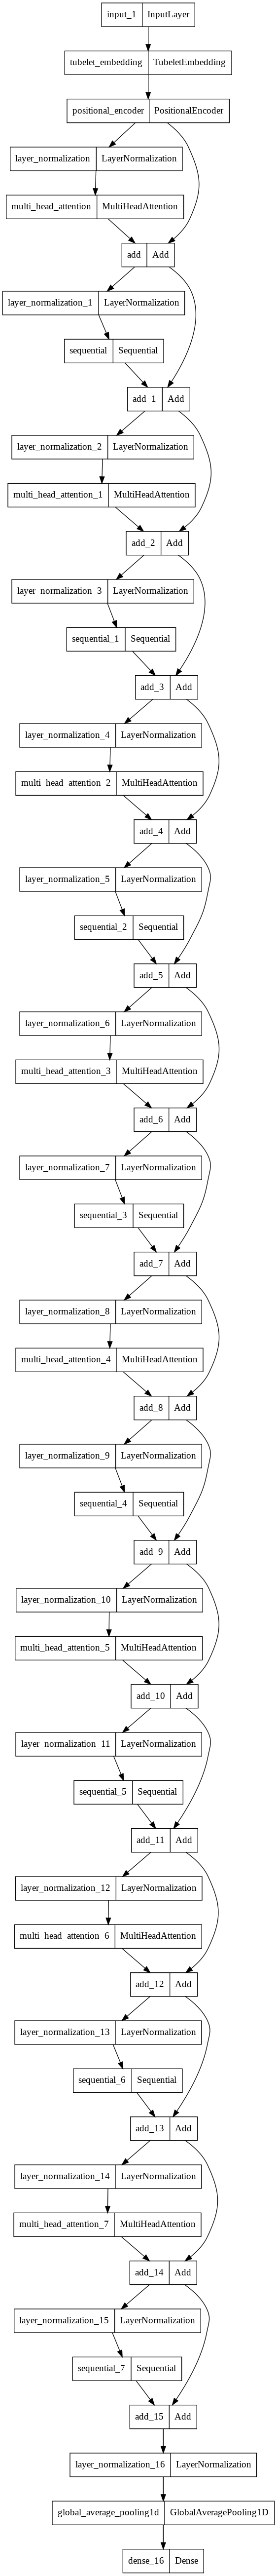

In [12]:
from tensorflow.keras.utils import plot_model

plot_model(model)